# Q1a) Normalizing the dataset

In [1]:
import pickle
import numpy as np
    
(train_X, train_y), (test_X, test_y) = pickle.load(open("mnist.pkl", "rb"))

train_X = train_X / np.max(train_X)
test_X = test_X / np.max(test_X)  
    

# Q1b) Completing the code and writing cross validation function

In [2]:
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks


def transformation(input_data):
    data = np.zeros((len(input_data),32*32))
    for i in range(len(input_data)):
        for j in range(32):
            for k in range(32):
                data[i,31*j + k] = input_data[i,j,k]
    return data   


In [3]:
from torch import nn
import torch
import matplotlib.pyplot as plt


class ann(nn.Module):
    def __init__(self):
        super(ann,self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1024,3),
            nn.Sigmoid(),
            nn.Linear(3,10),
            nn.Sigmoid(),
            nn.Linear(10,10),
        nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        return self.layers(x)

In [4]:
class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=transformation):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(),learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform

    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop,l2,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.FloatTensor(inputs)
        val_inputs = torch.FloatTensor(val_inputs)
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        l2_lambda=1e-5
        loss_fn = nn.CrossEntropyLoss()
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = np.argmax(self.model.forward(batch_input).detach().numpy(),axis=1)
                #print(self.model.forward(batch_input).shape)
                loss = loss_fn(self.model.forward(batch_input),torch.LongTensor(batch_output))
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + l2_lambda * l2_norm
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().item()*batch_importance
                epoch_acc += (1- np.count_nonzero(batch_output - batch_predictions)/len(batch))*batch_importance
                
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return self.model,{"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        @return
        losses: float
        acc: float
        """
        loss_fn = nn.CrossEntropyLoss()
        inputs = torch.FloatTensor(inputs) 
        losses = loss_fn(self.model.forward(inputs),torch.LongTensor(outputs)).item()
        predictions = np.argmax(self.model.forward(inputs).detach().numpy(),axis=1)
        acc = 1 - np.count_nonzero(outputs - predictions)/len(outputs)
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [5]:
from sklearn.model_selection import train_test_split,KFold

def train_and_val(model,train_X,train_y,epochs,batch_size,early_stop,l2,draw_curve=True):

    ### Split training examples further into training and validation ###
    train_in,valid_in,train_real,valid_real=train_test_split(train_X,train_y)
    ann_trainer = Trainer(model, "adam", 2e-3, epochs, batch_size)
    
    model,ledger  = ann_trainer.train(train_in,train_real,valid_in,valid_real,early_stop,l2)
    val_array = ledger['val_losses']
    train_array = ledger['losses']
    val_acc= ledger['val_accuracies']
    train_acc = ledger['accuracies']
       
    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
        plt.plot(np.arange(len(train_array))+1,train_array,label='Training loss')        
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_acc))+1,val_acc,label='Validation Accuracy')
        plt.plot(np.arange(len(train_acc))+1,train_acc,label='Training Accuracy')        
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
    ### Recover the model weight ###
    weights = model.parameters()

    return model,weights     

In [6]:

def Kfold(k,model,Xs,ys,epochs,batch_size,early_stop,l2):
    # The total number of examples for training the network
    
    total_num = len(Xs)
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # record error for each model
    train_error_all=[]
    test_error_all=[]
    weights = np.zeros(len(list(model.parameters())))
    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs= Xs[train_selector]
        test_Xs= Xs[test_selector]
        train_ys= ys[train_selector]
        test_ys= ys[test_selector]
        print(f" parameters:", sum([len(item.flatten()) for item in model.parameters()]))
        #model = ann()
        
        model, weights =train_and_val(model,train_Xs,train_ys,epochs,batch_size,early_stop,l2,draw_curve = True)

    return model,weights

In [7]:
def evaluate_ind(model, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        @return
        losses: float
        acc: float
        """
        loss_fn = nn.CrossEntropyLoss()
        inputs = torch.FloatTensor(inputs) 
        losses = loss_fn(model.forward(inputs),torch.LongTensor(outputs)).item()
        predictions = np.argmax(model.forward(inputs).detach().numpy(),axis=1)
        acc = 1 - np.count_nonzero(outputs - predictions)/len(outputs)
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

# Q1c) ANN with a hidden layer of 3

The error and accuracy graphs show the following:
1. Low accuracy it means errors have not reached sufficiently low values
2. large difference between training and validation error.

It seems like we are at both high bias and high variance situation. Low accuracies suggest that errros are not below acceptable error so we are in high bias situation. This implies we need add to more capacity which seems intuitive as a hidden layer of 3 neurons seems to small to solve such complex problems. The difference between training and validation error is also quite high, especially in 2nd and 3rd fold. This implies a high variance situation and maybe we need to do transform the features or in other words do principal component analysis. We also need to apply some regularization methods to reduce overfitting.

 parameters: 3225


  2%|▏         | 1/50 [00:00<00:13,  3.61it/s]

Epoch 1/50 - Loss: 2.282 - Acc: 0.183
              Val_loss: 2.234 - Val_acc: 0.221


 22%|██▏       | 11/50 [00:02<00:09,  3.97it/s]

Epoch 11/50 - Loss: 1.962 - Acc: 0.488
              Val_loss: 1.963 - Val_acc: 0.488


 42%|████▏     | 21/50 [00:05<00:07,  3.97it/s]

Epoch 21/50 - Loss: 1.903 - Acc: 0.568
              Val_loss: 1.902 - Val_acc: 0.566


 62%|██████▏   | 31/50 [00:07<00:04,  3.86it/s]

Epoch 31/50 - Loss: 1.787 - Acc: 0.711
              Val_loss: 1.790 - Val_acc: 0.705


 82%|████████▏ | 41/50 [00:10<00:02,  4.05it/s]

Epoch 41/50 - Loss: 1.737 - Acc: 0.745
              Val_loss: 1.748 - Val_acc: 0.729


func:'train'  took: 12.7742 sec
 parameters: 3225


  2%|▏         | 1/50 [00:00<00:14,  3.37it/s]

Epoch 1/50 - Loss: 1.726 - Acc: 0.748
              Val_loss: 1.730 - Val_acc: 0.744


 22%|██▏       | 11/50 [00:02<00:10,  3.83it/s]

Epoch 11/50 - Loss: 1.698 - Acc: 0.781
              Val_loss: 1.712 - Val_acc: 0.763


 42%|████▏     | 21/50 [00:05<00:07,  3.89it/s]

Epoch 21/50 - Loss: 1.683 - Acc: 0.793
              Val_loss: 1.701 - Val_acc: 0.773


 62%|██████▏   | 31/50 [00:08<00:05,  3.78it/s]

Epoch 31/50 - Loss: 1.673 - Acc: 0.801
              Val_loss: 1.697 - Val_acc: 0.776


 82%|████████▏ | 41/50 [00:10<00:02,  3.60it/s]

Epoch 41/50 - Loss: 1.666 - Acc: 0.806
              Val_loss: 1.690 - Val_acc: 0.778


func:'train'  took: 13.2090 sec
 parameters: 3225


  2%|▏         | 1/50 [00:00<00:12,  4.00it/s]

Epoch 1/50 - Loss: 1.676 - Acc: 0.793
              Val_loss: 1.676 - Val_acc: 0.792


 22%|██▏       | 11/50 [00:03<00:15,  2.48it/s]

Epoch 11/50 - Loss: 1.662 - Acc: 0.808
              Val_loss: 1.677 - Val_acc: 0.793


 42%|████▏     | 21/50 [00:07<00:10,  2.70it/s]

Epoch 21/50 - Loss: 1.656 - Acc: 0.814
              Val_loss: 1.672 - Val_acc: 0.795


 62%|██████▏   | 31/50 [00:10<00:04,  3.87it/s]

Epoch 31/50 - Loss: 1.652 - Acc: 0.818
              Val_loss: 1.671 - Val_acc: 0.798


 82%|████████▏ | 41/50 [00:12<00:02,  4.01it/s]

Epoch 41/50 - Loss: 1.649 - Acc: 0.821
              Val_loss: 1.672 - Val_acc: 0.795


func:'train'  took: 15.5992 sec


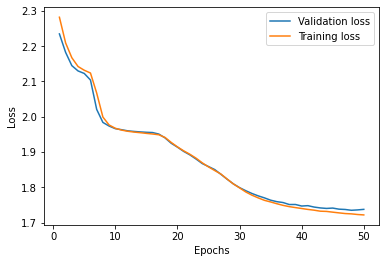

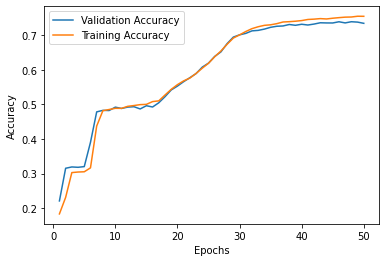

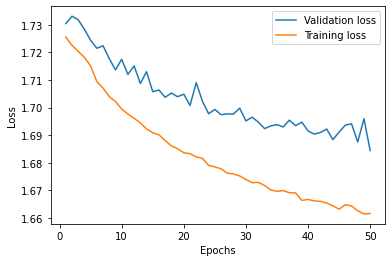

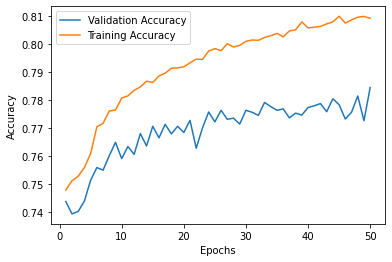

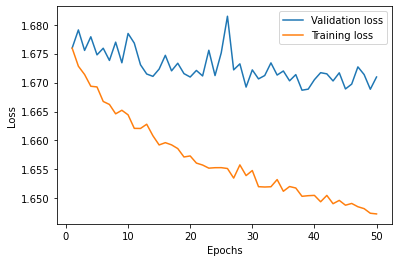

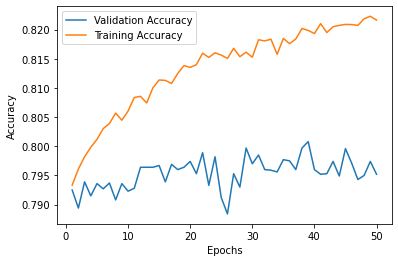

In [8]:
model1c = ann()

model1c, weights1c = Kfold(3,model1c,transformation(train_X),train_y,50,128,early_stop=True,l2=False)



In [9]:
print('Accuracy for the original test set using 1c')
answers1c = evaluate_ind(model1c,transformation(test_X), test_y, print_acc=True)

Accuracy for the original test set using 1c
Accuracy: 0.796


# Q1d) ANN with a hidden layer of 50

The error and accuracy graphs show similat features as before:
1. Low accuracy it means errors have not reached sufficiently low values 
2. large difference between training and validation error.

It seems like we are still at both high bias and high variance situation. However accuracies are much higher and errors are lower than 1c), this is because of increased capacity. Validation accuracy was around ~39% in case 1c) but with 50 hidden neurons it is around ~45%.

 parameters: 51870


  2%|▏         | 1/50 [00:00<00:41,  1.18it/s]

Epoch 1/50 - Loss: 2.174 - Acc: 0.365
              Val_loss: 2.010 - Val_acc: 0.608


 22%|██▏       | 11/50 [00:07<00:25,  1.50it/s]

Epoch 11/50 - Loss: 1.588 - Acc: 0.879
              Val_loss: 1.604 - Val_acc: 0.862


 42%|████▏     | 21/50 [00:12<00:13,  2.10it/s]

Epoch 21/50 - Loss: 1.494 - Acc: 0.973
              Val_loss: 1.520 - Val_acc: 0.946


 62%|██████▏   | 31/50 [00:16<00:08,  2.24it/s]

Epoch 31/50 - Loss: 1.483 - Acc: 0.981
              Val_loss: 1.516 - Val_acc: 0.948


 82%|████████▏ | 41/50 [00:20<00:04,  2.17it/s]

Epoch 41/50 - Loss: 1.479 - Acc: 0.984
              Val_loss: 1.514 - Val_acc: 0.949


func:'train'  took: 24.5098 sec
 parameters: 51870


  2%|▏         | 1/50 [00:00<00:23,  2.09it/s]

Epoch 1/50 - Loss: 1.499 - Acc: 0.963
              Val_loss: 1.496 - Val_acc: 0.967


 22%|██▏       | 11/50 [00:04<00:15,  2.55it/s]

Epoch 11/50 - Loss: 1.481 - Acc: 0.982
              Val_loss: 1.495 - Val_acc: 0.967


 42%|████▏     | 21/50 [00:08<00:11,  2.55it/s]

Epoch 21/50 - Loss: 1.477 - Acc: 0.985
              Val_loss: 1.496 - Val_acc: 0.967


 62%|██████▏   | 31/50 [00:12<00:07,  2.62it/s]

Epoch 31/50 - Loss: 1.476 - Acc: 0.986
              Val_loss: 1.496 - Val_acc: 0.966


 82%|████████▏ | 41/50 [00:16<00:03,  2.57it/s]

Epoch 41/50 - Loss: 1.473 - Acc: 0.988
              Val_loss: 1.495 - Val_acc: 0.967


func:'train'  took: 19.9751 sec
 parameters: 51870


  2%|▏         | 1/50 [00:00<00:21,  2.28it/s]

Epoch 1/50 - Loss: 1.487 - Acc: 0.974
              Val_loss: 1.488 - Val_acc: 0.973


 22%|██▏       | 11/50 [00:05<00:18,  2.07it/s]

Epoch 11/50 - Loss: 1.476 - Acc: 0.986
              Val_loss: 1.487 - Val_acc: 0.974


 42%|████▏     | 21/50 [00:09<00:13,  2.22it/s]

Epoch 21/50 - Loss: 1.476 - Acc: 0.986
              Val_loss: 1.489 - Val_acc: 0.973


 62%|██████▏   | 31/50 [00:15<00:09,  1.92it/s]

Epoch 31/50 - Loss: 1.473 - Acc: 0.988
              Val_loss: 1.490 - Val_acc: 0.972


 82%|████████▏ | 41/50 [00:19<00:03,  2.32it/s]

Epoch 41/50 - Loss: 1.473 - Acc: 0.989
              Val_loss: 1.490 - Val_acc: 0.972


func:'train'  took: 23.3554 sec


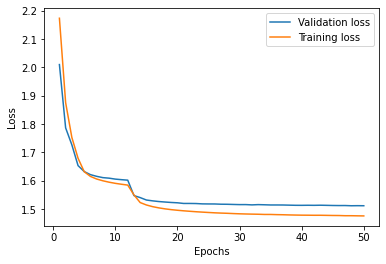

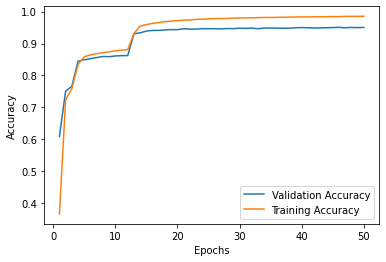

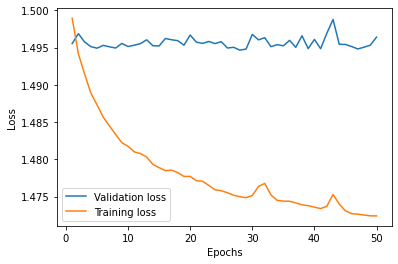

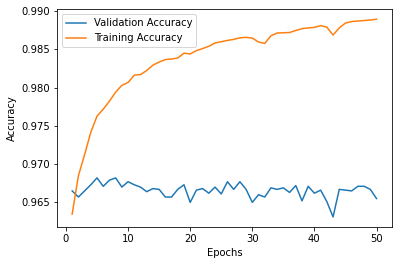

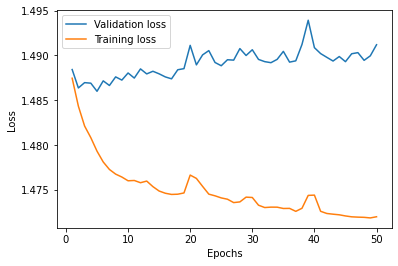

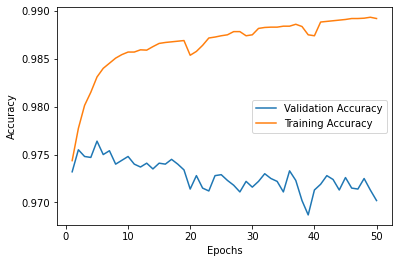

In [10]:
class ann_1d(nn.Module):
    def __init__(self):
        super(ann_1d,self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1024,50),
            nn.Sigmoid(),
            nn.Linear(50,10),
            nn.Sigmoid(),
            nn.Linear(10,10),
        nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        return self.layers(x)

model1d = ann_1d()

model1d, weights1d = Kfold(3,model1d,transformation(train_X),train_y,50,128,early_stop=True,l2=False)


In [11]:
print('Accuracy for the original test set using 1d')
answers1d = evaluate_ind(model1d,transformation(test_X), test_y, print_acc=True)

Accuracy for the original test set using 1d
Accuracy: 0.960


# Q2a) ANN with a hidden layer of 50 and dropout 15%

Dropout did not lead to any significant reduction in difference of errors between training and validation sets. As expected dropout reduces the extent of fitting and hence the validation accuracies also went down a little bit from ~45% to ~41%. The original test set accuracy remains almost the same = 0.099

 parameters: 51870


  2%|▏         | 1/50 [00:00<00:25,  1.95it/s]

Epoch 1/50 - Loss: 2.196 - Acc: 0.324
              Val_loss: 2.037 - Val_acc: 0.495


 22%|██▏       | 11/50 [00:04<00:17,  2.23it/s]

Epoch 11/50 - Loss: 1.529 - Acc: 0.816
              Val_loss: 1.543 - Val_acc: 0.794


 42%|████▏     | 21/50 [00:12<00:22,  1.26it/s]

Epoch 21/50 - Loss: 1.507 - Acc: 0.826
              Val_loss: 1.528 - Val_acc: 0.813


 62%|██████▏   | 31/50 [00:17<00:09,  2.06it/s]

Epoch 31/50 - Loss: 1.495 - Acc: 0.833
              Val_loss: 1.527 - Val_acc: 0.810


 82%|████████▏ | 41/50 [00:22<00:04,  2.12it/s]

Epoch 41/50 - Loss: 1.488 - Acc: 0.836
              Val_loss: 1.527 - Val_acc: 0.812


func:'train'  took: 28.2922 sec
 parameters: 51870


  2%|▏         | 1/50 [00:00<00:20,  2.43it/s]

Epoch 1/50 - Loss: 1.509 - Acc: 0.824
              Val_loss: 1.515 - Val_acc: 0.825


 22%|██▏       | 11/50 [00:05<00:18,  2.06it/s]

Epoch 11/50 - Loss: 1.494 - Acc: 0.838
              Val_loss: 1.511 - Val_acc: 0.820


 42%|████▏     | 21/50 [00:10<00:16,  1.79it/s]

Epoch 21/50 - Loss: 1.487 - Acc: 0.839
              Val_loss: 1.509 - Val_acc: 0.822


 62%|██████▏   | 31/50 [00:14<00:08,  2.33it/s]

Epoch 31/50 - Loss: 1.491 - Acc: 0.837
              Val_loss: 1.507 - Val_acc: 0.824


 82%|████████▏ | 41/50 [00:19<00:04,  2.21it/s]

Epoch 41/50 - Loss: 1.486 - Acc: 0.842
              Val_loss: 1.507 - Val_acc: 0.826


func:'train'  took: 22.9840 sec
 parameters: 51870


  2%|▏         | 1/50 [00:00<00:20,  2.41it/s]

Epoch 1/50 - Loss: 1.502 - Acc: 0.830
              Val_loss: 1.503 - Val_acc: 0.829


 22%|██▏       | 11/50 [00:04<00:15,  2.49it/s]

Epoch 11/50 - Loss: 1.487 - Acc: 0.839
              Val_loss: 1.500 - Val_acc: 0.832


 42%|████▏     | 21/50 [00:08<00:11,  2.54it/s]

Epoch 21/50 - Loss: 1.483 - Acc: 0.840
              Val_loss: 1.509 - Val_acc: 0.827


 62%|██████▏   | 31/50 [00:12<00:07,  2.60it/s]

Epoch 31/50 - Loss: 1.485 - Acc: 0.841
              Val_loss: 1.503 - Val_acc: 0.828


 82%|████████▏ | 41/50 [00:16<00:03,  2.31it/s]

Epoch 41/50 - Loss: 1.483 - Acc: 0.842
              Val_loss: 1.508 - Val_acc: 0.828


func:'train'  took: 19.9090 sec


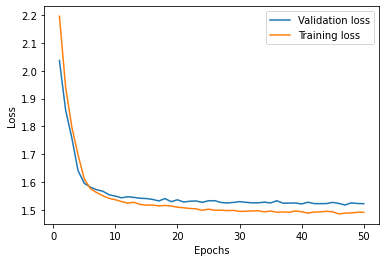

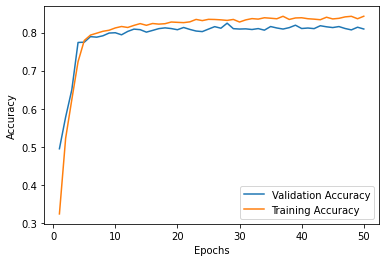

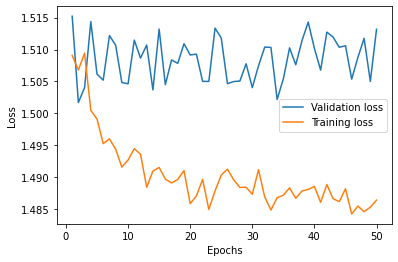

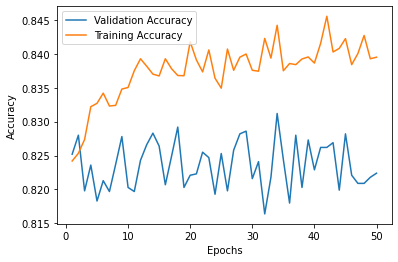

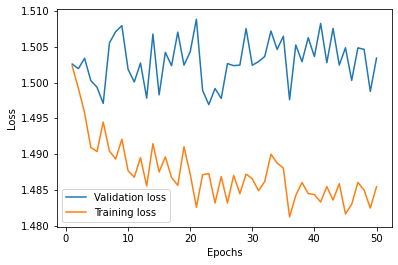

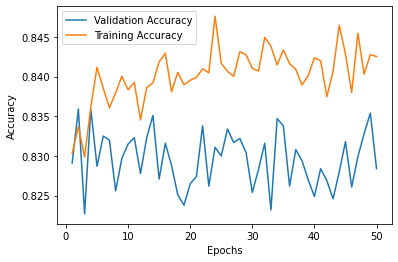

In [12]:
class ann_2a(nn.Module):
    def __init__(self):
        super(ann_2a,self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1024,50),
            nn.Sigmoid(),
            nn.Linear(50,10),
            nn.Sigmoid(),
            nn.Linear(10,10),
        nn.Softmax(dim=1),
            nn.Dropout(p=0.15)
        )
        
    def forward(self,x):
        return self.layers(x)
    
model2a = ann_2a()

model2a, weights2a = Kfold(3,model2a,transformation(train_X),train_y,50,128,early_stop=True,l2=False)


In [13]:
print('Accuracy for the original test set using 2a')
answers2a = evaluate_ind(model2a,transformation(test_X), test_y, print_acc=True)

Accuracy for the original test set using 2a
Accuracy: 0.816


# Q2b) ANN with a hidden layer of 50 and L2 regularization

As expected dropout reduces the overfitting. The difference between training and validation error is significantly lower now. However L2 regularization significantly reduced the error between training and validation sets thus significantly reducing overfitting.  As expected L2 regularization reduces the extent of fitting and hence the validation accuracies also went down a little bit from ~45% to ~41%. The original test set accuracy remains almost the same = 0.1

 parameters: 51870


  2%|▏         | 1/50 [00:00<00:22,  2.16it/s]

Epoch 1/50 - Loss: 2.193 - Acc: 0.334
              Val_loss: 2.053 - Val_acc: 0.566


 22%|██▏       | 11/50 [00:06<00:27,  1.43it/s]

Epoch 11/50 - Loss: 1.537 - Acc: 0.955
              Val_loss: 1.533 - Val_acc: 0.940


 42%|████▏     | 21/50 [00:14<00:21,  1.36it/s]

Epoch 21/50 - Loss: 1.511 - Acc: 0.978
              Val_loss: 1.514 - Val_acc: 0.954


 62%|██████▏   | 31/50 [00:21<00:13,  1.40it/s]

Epoch 31/50 - Loss: 1.504 - Acc: 0.985
              Val_loss: 1.510 - Val_acc: 0.957


 82%|████████▏ | 41/50 [00:28<00:06,  1.38it/s]

Epoch 41/50 - Loss: 1.500 - Acc: 0.988
              Val_loss: 1.508 - Val_acc: 0.958


func:'train'  took: 35.4548 sec
 parameters: 51870


  2%|▏         | 1/50 [00:00<00:47,  1.03it/s]

Epoch 1/50 - Loss: 1.516 - Acc: 0.972
              Val_loss: 1.493 - Val_acc: 0.974


 22%|██▏       | 11/50 [00:11<00:45,  1.18s/it]

Epoch 11/50 - Loss: 1.500 - Acc: 0.988
              Val_loss: 1.495 - Val_acc: 0.971


 42%|████▏     | 21/50 [00:22<00:28,  1.03it/s]

Epoch 21/50 - Loss: 1.497 - Acc: 0.991
              Val_loss: 1.497 - Val_acc: 0.969


 62%|██████▏   | 31/50 [00:31<00:16,  1.17it/s]

Epoch 31/50 - Loss: 1.496 - Acc: 0.992
              Val_loss: 1.498 - Val_acc: 0.969


 82%|████████▏ | 41/50 [00:41<00:08,  1.03it/s]

Epoch 41/50 - Loss: 1.495 - Acc: 0.993
              Val_loss: 1.499 - Val_acc: 0.967


func:'train'  took: 48.8293 sec
 parameters: 51870


  2%|▏         | 1/50 [00:00<00:38,  1.29it/s]

Epoch 1/50 - Loss: 1.510 - Acc: 0.979
              Val_loss: 1.490 - Val_acc: 0.976


 22%|██▏       | 11/50 [00:10<00:36,  1.08it/s]

Epoch 11/50 - Loss: 1.498 - Acc: 0.991
              Val_loss: 1.491 - Val_acc: 0.975


 42%|████▏     | 21/50 [00:19<00:26,  1.08it/s]

Epoch 21/50 - Loss: 1.495 - Acc: 0.993
              Val_loss: 1.493 - Val_acc: 0.975


 62%|██████▏   | 31/50 [00:30<00:22,  1.17s/it]

Epoch 31/50 - Loss: 1.494 - Acc: 0.994
              Val_loss: 1.495 - Val_acc: 0.971


 82%|████████▏ | 41/50 [00:40<00:08,  1.09it/s]

Epoch 41/50 - Loss: 1.494 - Acc: 0.995
              Val_loss: 1.495 - Val_acc: 0.972


func:'train'  took: 49.7052 sec


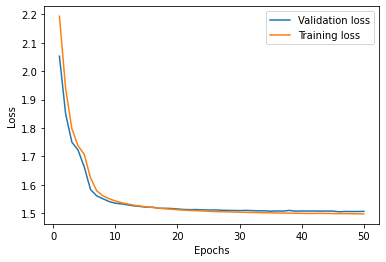

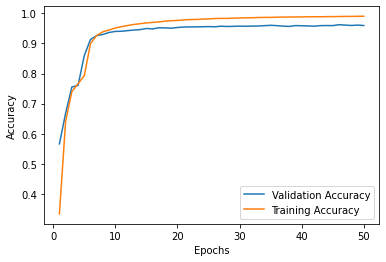

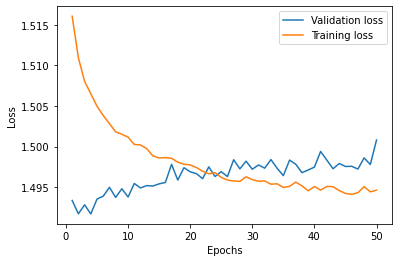

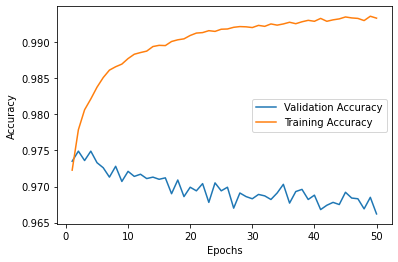

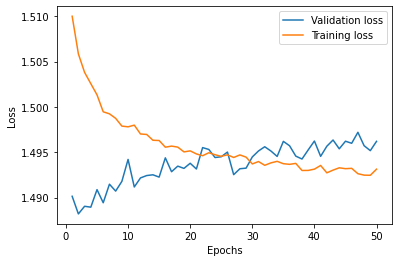

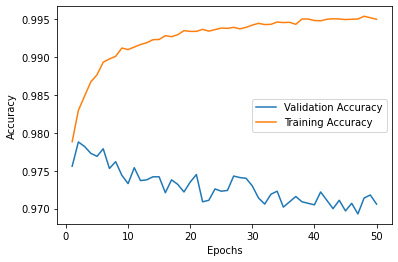

In [14]:
model2b = ann_1d()

model2b, weights2b = Kfold(3,model2b,transformation(train_X),train_y,50,128,early_stop=True,l2=True)


In [15]:
print('Accuracy for the original test set using 2b')
answers2b = evaluate_ind(model2b,transformation(test_X), test_y, print_acc=True)

Accuracy for the original test set using 2b
Accuracy: 0.969


# Q2c) Principal component analysis

After applying PCA and keeping 99% of the variance the new number of features is 393 which is significantly less than the original number of 1024.

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
x_pca=pca.fit_transform(transformation(train_X))

ans = pca.explained_variance_ratio_
print('Total percentage of variance kept: ' + str(np.sum(ans)))
print('New Shape: ' + str(x_pca.shape))

Total percentage of variance kept: 0.9900129426354098
New Shape: (60000, 331)


# Q2d) PCA, L2 and training

As the number of features are reduced training definitely becomes faster, it took ~15 sec after PCA compared to ~ 22 sec before PCA. As such the validation accuracies remain the same. The original test set accuracy also remains almost the same

 parameters: 17220


  2%|▏         | 1/50 [00:00<00:17,  2.80it/s]

Epoch 1/50 - Loss: 2.217 - Acc: 0.303
              Val_loss: 2.062 - Val_acc: 0.550


 22%|██▏       | 11/50 [00:08<00:45,  1.17s/it]

Epoch 11/50 - Loss: 1.592 - Acc: 0.913
              Val_loss: 1.577 - Val_acc: 0.908


 42%|████▏     | 21/50 [00:12<00:12,  2.41it/s]

Epoch 21/50 - Loss: 1.535 - Acc: 0.957
              Val_loss: 1.536 - Val_acc: 0.934


 62%|██████▏   | 31/50 [00:16<00:08,  2.17it/s]

Epoch 31/50 - Loss: 1.519 - Acc: 0.972
              Val_loss: 1.524 - Val_acc: 0.946


 82%|████████▏ | 41/50 [00:21<00:03,  2.50it/s]

Epoch 41/50 - Loss: 1.511 - Acc: 0.980
              Val_loss: 1.518 - Val_acc: 0.949


func:'train'  took: 24.3342 sec
 parameters: 17220


  2%|▏         | 1/50 [00:00<00:19,  2.55it/s]

Epoch 1/50 - Loss: 1.527 - Acc: 0.963
              Val_loss: 1.502 - Val_acc: 0.964


 22%|██▏       | 11/50 [00:04<00:14,  2.72it/s]

Epoch 11/50 - Loss: 1.507 - Acc: 0.984
              Val_loss: 1.503 - Val_acc: 0.964


 42%|████▏     | 21/50 [00:07<00:10,  2.75it/s]

Epoch 21/50 - Loss: 1.503 - Acc: 0.987
              Val_loss: 1.504 - Val_acc: 0.963


 62%|██████▏   | 31/50 [00:11<00:07,  2.69it/s]

Epoch 31/50 - Loss: 1.501 - Acc: 0.989
              Val_loss: 1.505 - Val_acc: 0.961


 82%|████████▏ | 41/50 [00:15<00:03,  2.79it/s]

Epoch 41/50 - Loss: 1.500 - Acc: 0.990
              Val_loss: 1.504 - Val_acc: 0.963


func:'train'  took: 18.5076 sec
 parameters: 17220


  2%|▏         | 1/50 [00:00<00:18,  2.67it/s]

Epoch 1/50 - Loss: 1.516 - Acc: 0.974
              Val_loss: 1.492 - Val_acc: 0.975


 22%|██▏       | 11/50 [00:04<00:14,  2.73it/s]

Epoch 11/50 - Loss: 1.499 - Acc: 0.991
              Val_loss: 1.497 - Val_acc: 0.971


 42%|████▏     | 21/50 [00:07<00:10,  2.74it/s]

Epoch 21/50 - Loss: 1.497 - Acc: 0.993
              Val_loss: 1.501 - Val_acc: 0.967


 62%|██████▏   | 31/50 [00:11<00:06,  2.94it/s]

Epoch 31/50 - Loss: 1.496 - Acc: 0.994
              Val_loss: 1.502 - Val_acc: 0.965


 82%|████████▏ | 41/50 [00:14<00:03,  2.97it/s]

Epoch 41/50 - Loss: 1.495 - Acc: 0.994
              Val_loss: 1.503 - Val_acc: 0.963


func:'train'  took: 17.6877 sec


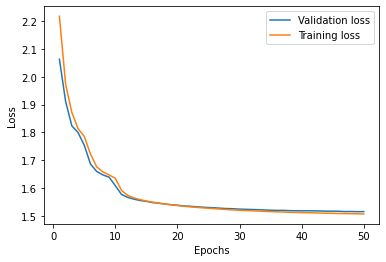

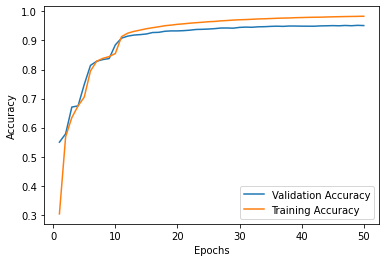

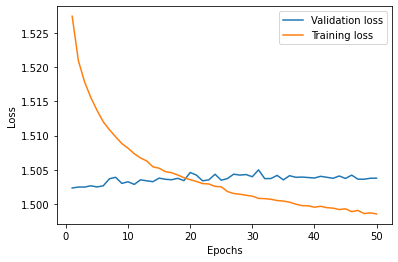

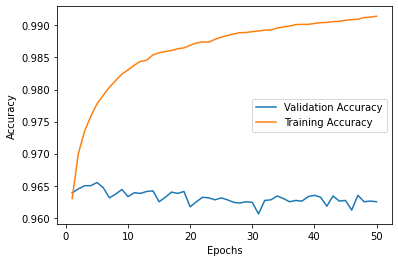

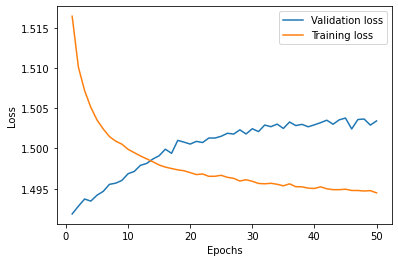

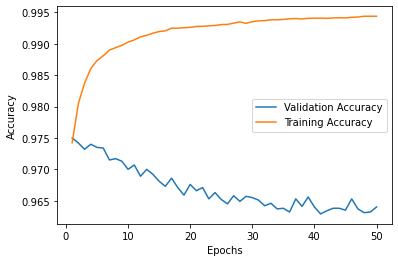

In [17]:
class ann_2d(nn.Module):
    def __init__(self):
        super(ann_2d,self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(x_pca.shape[1],50),
            nn.Sigmoid(),
            nn.Linear(50,10),
            nn.Sigmoid(),
            nn.Linear(10,10),
        nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        return self.layers(x)


model2d = ann_2d()

model2d, weights2d = Kfold(3,model2d,x_pca,train_y,50,128,early_stop=True,l2=True)